# Import data 

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

# Utility
import numpy as np
import os
from collections import Counter
import time
import pickle
import itertools

In [2]:
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

In [3]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]

data = pd.read_csv("data/tweets.csv", encoding ="ISO-8859-1" , names=DATASET_COLUMNS)

In [4]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
dataset= data[data['text'].notnull()]
dataset.reset_index(drop=True, inplace=True)
documents = dataset["text"][:10000]

In [6]:
documents.head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

data.target = data.target.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Dataset labels distribution')

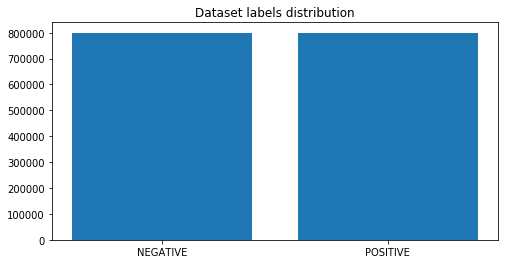

In [8]:
target_cnt = Counter(data.target)

plt.figure(figsize=(8,4))
plt.bar([tar for tar in target_cnt.keys()], [target_cnt[tar]for tar in target_cnt.keys()])
plt.title("Dataset labels distribution")

# Data Preprocessing

In [9]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

In [10]:
import nltk
nltk.set_proxy('http://10.225.92.1:80', user=None, password='')
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\F376507\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Lemmatize example

In [11]:
print(WordNetLemmatizer().lemmatize('went', pos='v'))

go


### Stemmer example

In [12]:
stemmer = SnowballStemmer('english')
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]
pd.DataFrame(data = {'original word': original_words, 'stemmed': singles})

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [13]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(lemmatize_stemming(token))
    return result


In [14]:
doc_sample = documents[:10].values[0]

In [15]:
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['@switchfoot', 'http://twitpic.com/2y1zl', '-', 'Awww,', "that's", 'a', 'bummer.', '', 'You', 'shoulda', 'got', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it.', ';D']


 tokenized and lemmatized document: 
['awww', 'bummer', 'shoulda', 'get', 'david', 'carr', 'day']


In [16]:
processed_docs = documents.map(preprocess)

In [17]:
processed_docs[:10]

0       [awww, bummer, shoulda, get, david, carr, day]
1    [upset, updat, facebook, text, result, school,...
2         [dive, time, ball, manag, save, rest, bound]
3                            [bodi, feel, itchi, like]
4                                         [behav, mad]
5                                               [crew]
6                                          [need, hug]
7    [hey, long, time, yes, rain, bite, bite, lol, ...
8                                               [nope]
9                                         [que, muera]
Name: text, dtype: object

# Bag of words on the dataset

In [18]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [19]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 awww
1 bummer
2 carr
3 david
4 day
5 get
6 shoulda
7 blah
8 facebook
9 result
10 school


In [20]:
#Filter out toke when they appearns feuw times and a lot of times
# And then keep the 100000 more frequent tokens
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [21]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[2]

[(11, 1), (12, 1), (13, 1), (14, 1)]

In [22]:
bow_doc_2 = bow_corpus[2]

for i in range(len(bow_doc_2)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2[i][0], 
                                                     dictionary[bow_doc_2[i][0]], 
                                                     bow_doc_2[i][1]))

Word 11 ("manag") appears 1 time.
Word 12 ("rest") appears 1 time.
Word 13 ("save") appears 1 time.
Word 14 ("time") appears 1 time.


# TF-IDF

In [23]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)

In [24]:
corpus_tfidf = tfidf[bow_corpus]

In [25]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5964669800362361),
 (1, 0.6827273885013042),
 (2, 0.2964472836056829),
 (3, 0.3003821944780571)]


# Option 1 : Running LDA using Bag of Words WORST

In [26]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [27]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.039*"get" + 0.027*"sleep" + 0.016*"day" + 0.016*"think" + 0.015*"work" + 0.014*"tire" + 0.013*"wait" + 0.013*"bore" + 0.011*"omg" + 0.011*"need"
Topic: 1 
Words: 0.043*"good" + 0.032*"sorri" + 0.032*"miss" + 0.025*"day" + 0.019*"today" + 0.018*"time" + 0.014*"morn" + 0.014*"lol" + 0.014*"hope" + 0.013*"year"
Topic: 2 
Words: 0.053*"quot" + 0.038*"miss" + 0.028*"wish" + 0.028*"work" + 0.024*"night" + 0.023*"think" + 0.016*"go" + 0.012*"fun" + 0.012*"get" + 0.012*"day"
Topic: 3 
Words: 0.026*"know" + 0.023*"work" + 0.023*"hear" + 0.022*"sorri" + 0.016*"snow" + 0.015*"want" + 0.015*"sick" + 0.014*"start" + 0.013*"poor" + 0.013*"sad"
Topic: 4 
Words: 0.034*"go" + 0.030*"feel" + 0.030*"day" + 0.026*"like" + 0.022*"work" + 0.017*"sleep" + 0.016*"right" + 0.015*"wish" + 0.014*"play" + 0.014*"time"
Topic: 5 
Words: 0.047*"like" + 0.035*"day" + 0.033*"work" + 0.028*"go" + 0.020*"come" + 0.018*"feel" + 0.017*"quot" + 0.013*"tomorrow" + 0.012*"tri" + 0.012*"way"
Topic: 6 
Words

# Option 2 : Running LDA using TF-IDF BEST

In [28]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [29]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.027*"sleep" + 0.022*"wish" + 0.016*"follow" + 0.015*"break" + 0.013*"need" + 0.011*"drink" + 0.010*"school" + 0.010*"car" + 0.010*"amp" + 0.010*"think"
Topic: 1 Word: 0.030*"twitter" + 0.028*"watch" + 0.014*"wait" + 0.011*"man" + 0.011*"quot" + 0.011*"eat" + 0.011*"send" + 0.010*"day" + 0.010*"okay" + 0.009*"break"
Topic: 2 Word: 0.043*"want" + 0.022*"like" + 0.021*"friend" + 0.014*"phone" + 0.013*"peopl" + 0.013*"get" + 0.011*"go" + 0.010*"earli" + 0.010*"pic" + 0.009*"miss"
Topic: 3 Word: 0.019*"go" + 0.015*"miss" + 0.015*"need" + 0.014*"work" + 0.014*"good" + 0.014*"home" + 0.013*"today" + 0.013*"morn" + 0.012*"thank" + 0.011*"sick"
Topic: 4 Word: 0.047*"work" + 0.035*"feel" + 0.015*"sit" + 0.014*"good" + 0.014*"go" + 0.013*"bad" + 0.013*"today" + 0.013*"better" + 0.012*"ill" + 0.011*"time"
Topic: 5 Word: 0.026*"sorri" + 0.019*"home" + 0.016*"fun" + 0.015*"time" + 0.014*"go" + 0.014*"class" + 0.012*"day" + 0.012*"week" + 0.011*"aww" + 0.011*"think"
Topic: 6 Word: 0.

# Classification of the topics

### Performance evaluation by classifying sample document using LDA Bag of Words model

In [30]:
processed_docs[2]

['dive', 'time', 'ball', 'manag', 'save', 'rest', 'bound']

In [31]:
for index, score in sorted(lda_model[bow_corpus[2]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.8198950886726379	 
Topic: 0.026*"know" + 0.023*"work" + 0.023*"hear" + 0.022*"sorri" + 0.016*"snow" + 0.015*"want" + 0.015*"sick" + 0.014*"start" + 0.013*"poor" + 0.013*"sad"

Score: 0.02001735381782055	 
Topic: 0.043*"good" + 0.032*"sorri" + 0.032*"miss" + 0.025*"day" + 0.019*"today" + 0.018*"time" + 0.014*"morn" + 0.014*"lol" + 0.014*"hope" + 0.013*"year"

Score: 0.02001594379544258	 
Topic: 0.047*"like" + 0.035*"day" + 0.033*"work" + 0.028*"go" + 0.020*"come" + 0.018*"feel" + 0.017*"quot" + 0.013*"tomorrow" + 0.012*"tri" + 0.012*"way"

Score: 0.020012496039271355	 
Topic: 0.034*"go" + 0.030*"feel" + 0.030*"day" + 0.026*"like" + 0.022*"work" + 0.017*"sleep" + 0.016*"right" + 0.015*"wish" + 0.014*"play" + 0.014*"time"

Score: 0.020012298598885536	 
Topic: 0.039*"get" + 0.027*"sleep" + 0.016*"day" + 0.016*"think" + 0.015*"work" + 0.014*"tire" + 0.013*"wait" + 0.013*"bore" + 0.011*"omg" + 0.011*"need"

Score: 0.020010897889733315	 
Topic: 0.030*"twitter" + 0.028*"want" + 0.027

### Performance evaluation by classifying sample document using LDA TF-IDF model

In [32]:
for index, score in sorted(lda_model_tfidf[bow_corpus[2]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.8199706673622131	 
Topic: 0.026*"sorri" + 0.019*"home" + 0.016*"fun" + 0.015*"time" + 0.014*"go" + 0.014*"class" + 0.012*"day" + 0.012*"week" + 0.011*"aww" + 0.011*"think"

Score: 0.020005393773317337	 
Topic: 0.026*"quot" + 0.021*"suck" + 0.020*"hope" + 0.020*"love" + 0.017*"snow" + 0.014*"gonna" + 0.013*"sick" + 0.013*"work" + 0.012*"lol" + 0.011*"day"

Score: 0.020003817975521088	 
Topic: 0.043*"want" + 0.022*"like" + 0.021*"friend" + 0.014*"phone" + 0.013*"peopl" + 0.013*"get" + 0.011*"go" + 0.010*"earli" + 0.010*"pic" + 0.009*"miss"

Score: 0.02000374346971512	 
Topic: 0.019*"go" + 0.015*"miss" + 0.015*"need" + 0.014*"work" + 0.014*"good" + 0.014*"home" + 0.013*"today" + 0.013*"morn" + 0.012*"thank" + 0.011*"sick"

Score: 0.020003413781523705	 
Topic: 0.047*"work" + 0.035*"feel" + 0.015*"sit" + 0.014*"good" + 0.014*"go" + 0.013*"bad" + 0.013*"today" + 0.013*"better" + 0.012*"ill" + 0.011*"time"

Score: 0.02000339888036251	 
Topic: 0.030*"twitter" + 0.028*"watch" + 0.014*

# Testing model on unseen document

In [36]:
unseen_document = 'I love my day'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.6998245716094971	 Topic: 0.030*"twitter" + 0.028*"want" + 0.027*"home" + 0.023*"love" + 0.020*"cold"
Score: 0.03337667137384415	 Topic: 0.047*"like" + 0.035*"day" + 0.033*"work" + 0.028*"go" + 0.020*"come"
Score: 0.03336497023701668	 Topic: 0.034*"go" + 0.030*"feel" + 0.030*"day" + 0.026*"like" + 0.022*"work"
Score: 0.03336025029420853	 Topic: 0.043*"good" + 0.032*"sorri" + 0.032*"miss" + 0.025*"day" + 0.019*"today"
Score: 0.03335464000701904	 Topic: 0.058*"work" + 0.026*"want" + 0.023*"get" + 0.023*"miss" + 0.019*"day"
Score: 0.033350951969623566	 Topic: 0.039*"get" + 0.027*"sleep" + 0.016*"day" + 0.016*"think" + 0.015*"work"
Score: 0.033345382660627365	 Topic: 0.053*"quot" + 0.038*"miss" + 0.028*"wish" + 0.028*"work" + 0.024*"night"
Score: 0.0333435945212841	 Topic: 0.056*"today" + 0.023*"want" + 0.022*"go" + 0.020*"work" + 0.019*"hate"
Score: 0.03334028273820877	 Topic: 0.049*"sad" + 0.037*"feel" + 0.019*"break" + 0.018*"think" + 0.017*"better"
Score: 0.03333865851163864	 T